In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


data = pd.read_csv("/home/ec2-user/clean_data/classC_ship1_MRG_sort.csv", encoding="utf-8")

## Visualizing cross correlations

The below figure shows how each sensor is correlated with each other sensor in the Class C Ship 1 MRG. The red squares show which pairs of measurements are most correlated.

/home/ec2-user/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


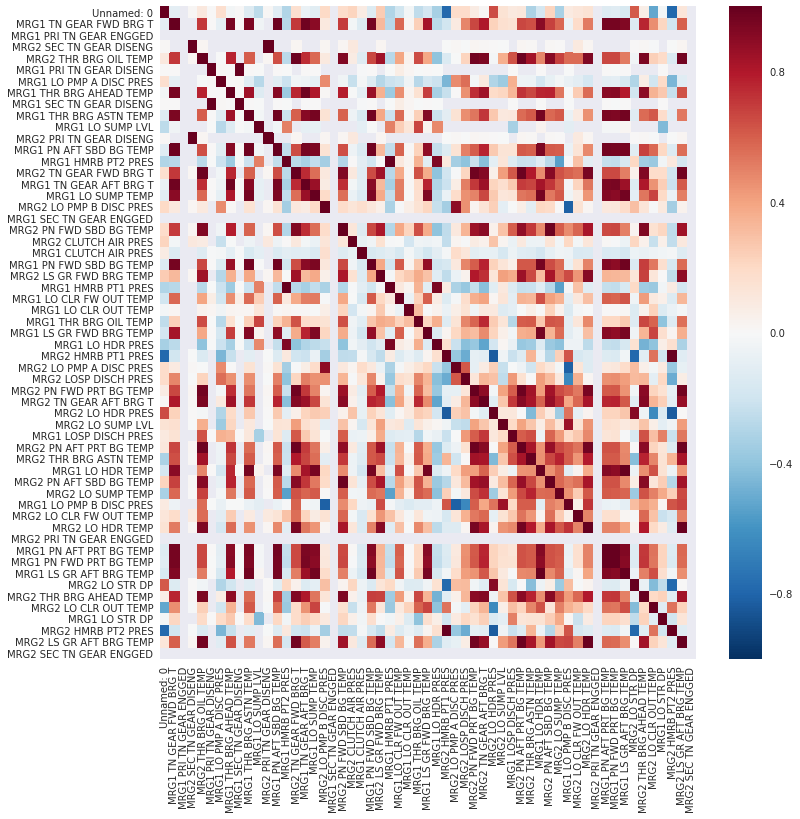

In [2]:
plt.figure(figsize=(12,12))
c = data.corr()
sns.heatmap(c)

In [3]:
mrg1 = ["MRG1" in varname for varname in data.columns]    

In [4]:
data.columns[mrg1]

Index([u'MRG1 TN GEAR FWD BRG T', u'MRG1 PRI TN GEAR ENGGED',
       u'MRG1 PRI TN GEAR DISENG', u'MRG1 LO PMP A DISC PRES',
       u'MRG1 THR BRG AHEAD TEMP', u'MRG1 SEC TN GEAR DISENG',
       u'MRG1 THR BRG ASTN TEMP', u'MRG1 LO SUMP LVL',
       u'MRG1 PN AFT SBD BG TEMP', u'MRG1 HMRB PT2 PRES',
       u'MRG1 TN GEAR AFT BRG T', u'MRG1 LO SUMP TEMP',
       u'MRG1 SEC TN GEAR ENGGED', u'MRG1 CLUTCH AIR PRES',
       u'MRG1 PN FWD SBD BG TEMP', u'MRG1 HMRB PT1 PRES',
       u'MRG1 LO CLR FW OUT TEMP', u'MRG1 LO CLR OUT TEMP',
       u'MRG1 THR BRG OIL TEMP', u'MRG1 LS GR FWD BRG TEMP',
       u'MRG1 LO HDR PRES', u'MRG1 LOSP DISCH PRES', u'MRG1 LO HDR TEMP',
       u'MRG1 LO PMP B DISC PRES', u'MRG1 PN AFT PRT BG TEMP',
       u'MRG1 PN FWD PRT BG TEMP', u'MRG1 LS GR AFT BRG TEMP',
       u'MRG1 LO STR DP'],
      dtype='object')

In [5]:
mrg1_corrs = data[data.columns[mrg1]].corr()

Below is the correlation map for only the MRG1 quantities

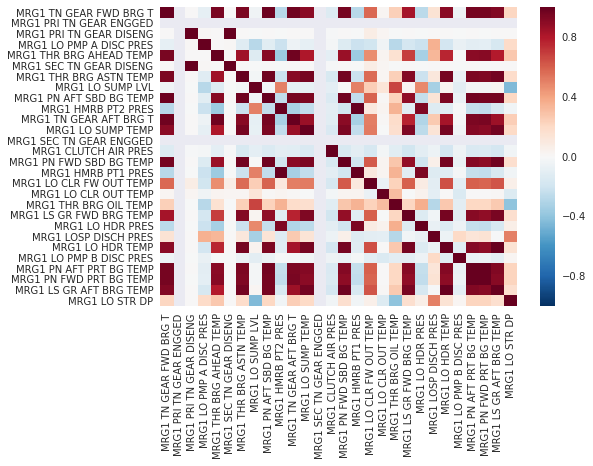

In [6]:
sns.heatmap(mrg1_corrs)

## Computing the time evolution of cross correlations

In [7]:
import scipy.stats

def correlation_deviations(correlations, mean_correlation):
    std_correlation = np.std(correlations)
    gauss = scipy.stats.norm(mean_correlation, std_correlation)
    
    probs = gauss.pdf(correlations)
    
    return probs    

In [9]:
from pandas.tseries.offsets import DateOffset
import datetime

def corr_time_window(start_time, window, data):
    times = pd.to_datetime(data['timeFormat'])
    data['timeFormat'] = times
    sel_rows = data[data["timeFormat"] == start_time]
    
    start_time = pd.to_datetime(start_time)
    offset = pd.to_datetime(start_time) + DateOffset(hours=window)
    data = data.set_index("timeFormat")
    selected = data[start_time : offset]

    # if ten minute samples, should have 6 per hour - make it 4 for a little tolerance
    if selected.shape[0] < window*6:
        return None
    else:
        return selected.corr()

In [10]:
data.shape

(40660, 60)

In [11]:
def correlation_trends(data, windowsize, columns):
    corrs = [0 for _ in data["timeFormat"]]

    for i,time in enumerate(np.array(data["timeFormat"])):
        if i%1000 == 0:
            print i
        #curr_mat = corr_time_window(time, 6, data[["timeFormat", "MRG1 PN FWD PRT BG TEMP", "MRG1 PN AFT PRT BG TEMP"]])
        #corrs[i] = np.nan if curr_mat is None else curr_mat.loc["MRG1 PN FWD PRT BG TEMP", "MRG1 PN AFT PRT BG TEMP"]
        curr_mat = corr_time_window(time, 6, data[["timeFormat"] + columns])
        corrs[i] = np.nan if curr_mat is None else curr_mat.loc[columns[0], columns[1]]
        
    return corrs

In [23]:
tmp_corr = correlation_trends(data.loc[1:200], 6, ["MRG1 PN FWD PRT BG TEMP", "MRG1 PN AFT PRT BG TEMP"])
subset1 = data["MRG1 PN FWD PRT BG TEMP"].loc[1:200]
subset2 = data["MRG1 PN AFT PRT BG TEMP"].loc[1:200]
sstimes = pd.to_datetime(data["timeFormat"].loc[1:200])

0


/home/ec2-user/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
sel = np.where(np.logical_not(np.isnan(tmp_corr)))[0]
tmp_corr = np.array(tmp_corr)[sel]
subset1 = subset1[sel]
subset2 = subset2[sel]
sstimes = sstimes[sel]

In [25]:
subset1.shape

(152,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

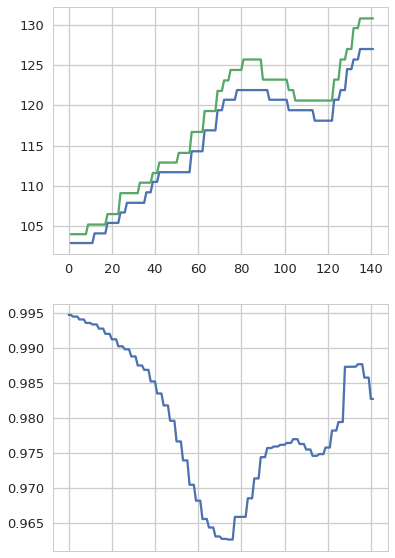

In [49]:
sns.set_context("talk", font_scale=1.0)
sns.set_style("whitegrid")
plt.figure(figsize=(6,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)

ax1.plot(subset1[0:-10], label="FWD sensor")
ax1.plot(subset2[0:-10], label="AFT sensor")
ax2.plot(tmp_corr[0:-10])
plt.setp(ax1.get_xticklabels(), visible=False)
#ax2.ylim(0.9, 1.0)
#plt.xlabel("Sample")
#plt.ylabel("Port bearing temperature")
#plt.legend()
#plt.show()

In [32]:
def two_scales(ax1, time, data1, data2, c1, c2):
    """

    Parameters
    ----------
    ax : axis
        Axis to put two scales on

    time : array-like
        x-axis values for both datasets

    data1: array-like
        Data for left hand scale

    data2 : array-like
        Data for right hand scale

    c1 : color
        Color for line 1

    c2 : color
        Color for line 2

    Returns
    -------
    ax : axis
        Original axis
    ax2 : axis
        New twin axis
    """
    ax2 = ax1.twinx()

    ax1.plot(time, data1, color=c1)
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('exp')

    ax2.plot(time, data2, color=c2)
    ax2.set_ylabel('sin')
    return ax1, ax2

In [ ]:
fig, ax = plt.subplots()
two_scales(ax, np.arange(0, subset1[0:-10].shape[0]), )

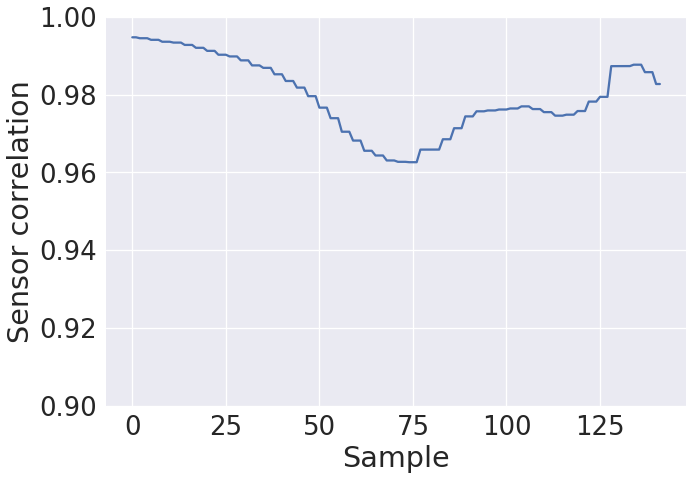

In [31]:
sns.set_context("talk", font_scale=2.0)
plt.plot(tmp_corr[0:-10])
plt.ylim(0.9, 1.0)
plt.xlabel("Sample")
plt.ylabel("Sensor correlation")
plt.show()